In [1]:
import sys, os
sys.path.insert(0, "/home/storage/hans/jax_reco_new")
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import jax.numpy as jnp
from jax.scipy import optimize
import jax
jax.config.update("jax_enable_x64", True)

import tensorflow as tf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from lib.simdata_i3 import I3SimHandlerFtr, I3SimBatchHandler
from lib.geo import center_track_pos_and_time_based_on_data
from lib.experimental_methods import remove_early_pulses

from lib.network import get_network_eval_v_fn
from dom_track_eval import get_eval_network_doms_and_track

In [2]:
# Get an IceCube event.
bp = '/home/storage2/hans/i3files/21217'
sim_handler = I3SimHandlerFtr(os.path.join(bp, 'meta_ds_21217_from_35000_to_53530.ftr'),
                              os.path.join(bp, 'pulses_ds_21217_from_35000_to_53530.ftr'),
                              '/home/storage/hans/jax_reco/data/icecube/detector_geometry.csv')

In [3]:
dtype = jnp.float32
eval_network_v = get_network_eval_v_fn(bpath='/home/storage/hans/jax_reco/data/network', dtype=dtype)
eval_network_doms_and_track = get_eval_network_doms_and_track(eval_network_v, dtype=dtype)

In [4]:
batch_maker = I3SimBatchHandler(sim_handler, batch_size=256)

In [16]:
batch_iter = batch_maker.get_batch_iterator()

In [22]:
data, mctruth = batch_iter.next()
orig_length = data.shape[1]

data = jnp.array(data.numpy())
mctruth = jnp.array(mctruth.numpy())
print(data.shape)

(236, 57, 5)


In [23]:
idx = 4
d = data[idx]
t = mctruth[idx]
print(d.shape)
print(t.shape)

(57, 5)
(14,)


In [24]:
track_src = t[2:4]
track_time = t[4]
track_pos = t[5:8]
print(track_src)
print(track_time)
print(track_pos)

[1.7120085  1.97806303]
8206.210111467168
[ 20.75878096 758.2919048  189.86856164]


In [25]:
d_clean = remove_early_pulses(eval_network_doms_and_track, 
                              d, 
                              track_pos, 
                              track_src, 
                              track_time)

In [26]:
print(d_clean.shape)
print(d_clean[-1])

(47, 5)
[2.21100000e+01 5.09500000e+02 1.64250000e+02 9.66500000e+03
 9.25000012e-01]


In [27]:
#d_clean_padded = jnp.pad(d_clean, ((0, orig_length-d_clean.shape[0]), (0, 0)))

In [28]:
def get_clean_pulses_fn(eval_network_doms_and_track_fn, orig_length):
    
    def clean_pulses(data, mctruth):
        track_src = mctruth[2:4]
        track_time = mctruth[4]
        track_pos = mctruth[5:8]
        
        crit = -60.0
        _, _, _, geo_times = eval_network_doms_and_track_fn(data[:,:3], track_pos, track_src)
        delay_times = data[:, 3] - geo_times - track_time
        print(jnp.sort(delay_times))
        idx = delay_times > crit
        idx = idx.reshape((orig_length, 1))
        data_clean = jnp.where(idx, data, jnp.zeros((1,5)))
        return data_clean

    return clean_pulses

In [29]:
clean_pulses = get_clean_pulses_fn(eval_network_doms_and_track, orig_length)

In [30]:
clean_pulses_v = jax.jit(jax.vmap(clean_pulses, (0, 0), 0))

In [31]:
d_clean_padded = clean_pulses(d, t)
print(d_clean_padded.shape)
print(d_clean_padded[-10:])

[-1.16316073e+04 -1.16316073e+04 -1.16316073e+04 -1.16316073e+04
 -1.16316073e+04 -1.16316073e+04 -1.16316073e+04 -1.16316073e+04
 -1.16316073e+04 -1.33882909e+03 -1.85382945e+00  7.62886007e-01
  8.73802628e+00  1.50349678e+01  1.62934540e+01  1.66266386e+01
  2.24385368e+01  2.27390636e+01  3.37424154e+01  3.50367533e+01
  3.63990126e+01  4.40033054e+01  4.42291976e+01  8.85481632e+01
  1.07817373e+02  1.10189252e+02  1.10336044e+02  1.41077954e+02
  1.78449127e+02  2.05628962e+02  2.10135217e+02  2.38654421e+02
  2.56049653e+02  2.67245843e+02  3.45848528e+02  3.86403356e+02
  3.90185580e+02  3.97665303e+02  4.05512550e+02  4.73953967e+02
  4.89887398e+02  5.43740809e+02  5.89941030e+02  5.99871643e+02
  6.12891840e+02  6.68987429e+02  7.05525014e+02  7.11693031e+02
  7.57015641e+02  7.61952042e+02  7.64525147e+02  7.70616666e+02
  7.88048578e+02  8.12769271e+02  9.33431486e+02  1.36167439e+03
  1.58418850e+03]
(57, 5)
[[2.21100000e+01 5.09500000e+02 1.64250000e+02 9.66500000e+03
  

In [32]:
data_clean_padded = clean_pulses_v(data, mctruth)

Traced<ShapedArray(float64[57])>with<BatchTrace(level=2/0)> with
  val = Traced<ShapedArray(float64[236,57])>with<DynamicJaxprTrace(level=1/0)>
  batch_dim = 0


In [33]:
data_clean_padded.shape

(236, 57, 5)

In [34]:
from likelihood_spe_batched import get_neg_c_triple_gamma_llh
from lib.geo import get_xyz_from_zenith_azimuth, __c

In [35]:
def center_track_pos_and_time_based_on_data(data, mctruth):
    track_dir = mctruth[2:4]
    track_time = mctruth[4]
    track_pos = mctruth[5:8]
    
    track_dir_xyz = get_xyz_from_zenith_azimuth(track_dir)
    charge = data[:, 4]
    time = data[:, 3]
    
    centered_track_time = np.sum(charge * time) / np.sum(charge)
    centered_track_pos = track_pos + (centered_track_time - track_time) * __c * track_dir_xyz
    return jnp.array(centered_track_pos), jnp.float64(centered_track_time)

center_track_pos_and_time_based_on_data_v = jax.jit(jax.vmap(center_track_pos_and_time_based_on_data,
                                                            (0, 0),
                                                            (0, 0)))

In [36]:
centered_track_pos, centered_track_time = center_track_pos_and_time_based_on_data(
    d_clean_padded, t
)

In [37]:
centered_track_pos, centered_track_time

(Array([267.12260953, 187.19279924, 278.2870948 ], dtype=float64),
 Array(10301.74450454, dtype=float64))

In [38]:
neg_llh = get_neg_c_triple_gamma_llh(eval_network_doms_and_track)

In [39]:
print(neg_llh(track_src, centered_track_pos, centered_track_time, d_clean_padded))

608.084529079064


In [40]:
centered_track_positions, centered_track_times = center_track_pos_and_time_based_on_data_v(
    data_clean_padded, mctruth)

In [41]:
print(centered_track_positions[4])

[267.12260953 187.19279924 278.2870948 ]


In [42]:
import optimistix as optx 

scale = 20.0
@jax.jit
def neg_llh_5D(x, args):
        centered_track_time = args[0]
        fitting_event_data = args[1]
		# project back if outside of [0, pi] x [0, 2*pi]
        zenith = x[0] / scale
        azimuth = x[1] / scale
        zenith = jnp.fmod(zenith, 2.0*jnp.pi)
        zenith = jnp.where(zenith < 0, zenith+2.0*jnp.pi, zenith)
        cond = zenith > jnp.pi
        zenith = jnp.where(cond, -1.0*zenith+2.0*jnp.pi, zenith)
        azimuth = jnp.where(cond, azimuth-jnp.pi, azimuth)

        azimuth = jnp.fmod(azimuth, 2.0*jnp.pi)
        azimuth = jnp.where(azimuth < 0, azimuth+2.0*jnp.pi, azimuth)

        projected_dir = jnp.array([zenith, azimuth])
        return neg_llh(projected_dir, x[2:]*scale, centered_track_time, fitting_event_data)

In [43]:
args=[centered_track_time, d_clean_padded]
solver = optx.BFGS(rtol=1e-7, atol=1e-3, use_inverse=True)
x0 = jnp.concatenate([track_src*scale, centered_track_pos/scale])
best_x = optx.minimise(neg_llh_5D, solver, x0, args=args).value
best_logl = neg_llh_5D(best_x, args=args)

In [44]:
print(best_logl)

597.523655243718


In [45]:
def optimize_one_event(data, track_src, centered_track_time, centered_track_pos):
    args=[centered_track_time, data]
    solver = optx.BFGS(rtol=1e-7, atol=1e-3, use_inverse=True)
    x0 = jnp.concatenate([track_src*scale, centered_track_pos/scale])
    best_x = optx.minimise(neg_llh_5D, solver, x0, args=args).value
    best_logl = neg_llh_5D(best_x, args=args)
    return best_logl, best_x

In [46]:
bl, bx = optimize_one_event(d_clean_padded, track_src, centered_track_time, centered_track_pos)

In [47]:
print(bl, bx)

597.523655243718 [34.30321955 39.6672538  13.28365175  9.31181204 14.00355037]


In [48]:
optimize_batch = jax.jit(jax.vmap(optimize_one_event, (0, 0, 0, 0), (0, 0)))

In [49]:
track_src_v = mctruth[:, 2:4]
bl, bx = optimize_batch(data_clean_padded, track_src_v, centered_track_times, centered_track_positions)

In [50]:
bl.shape

(236,)

In [51]:
bx

Array([[ 40.39044758,  36.80280648,  20.1768865 ,   7.98255375,
        -11.79971403],
       [ 53.31875854, 104.64711352,  -1.25005203,  20.14845988,
         -7.8267977 ],
       [ 41.14898961,  70.15126523,   7.58854976,  -2.87280113,
          2.68714553],
       ...,
       [ 54.67202049, 104.56433041,  13.51242841, -16.89500909,
         10.69555823],
       [ 34.12016352, 104.09423053,   5.75724124,  14.34410212,
         13.68296215],
       [ 32.78091287,  91.42869069,  -7.09815237,  -3.4128863 ,
          3.91346566]], dtype=float64)

In [52]:
%timeit optimize_batch(data_clean_padded, track_src_v, centered_track_times, centered_track_positions)

1.39 s ± 939 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [53]:
reco_zenith, reco_azimuth = bx[:, 0]/scale, bx[:, 1]/scale

In [54]:
true_zenith, true_azimuth = track_src_v[:, 0], track_src_v[:, 1]

In [55]:
smpe_zenith, smpe_azimuth = mctruth[:, 8], mctruth[:, 9]

In [56]:
def GreatCircleDistance(azi_1, zen_1, azi_2, zen_2):
        ra_1 = azi_1
        ra_2 = azi_2
        dec_1 = np.pi/2.0 - zen_1
        dec_2 = np.pi/2.0 - zen_2
        '''Compute the great circle distance between two events'''
        '''All coordinates must be given in radians'''
        delta_dec = np.abs(dec_1 - dec_2)
        delta_ra = np.abs(ra_1 - ra_2)
        x = (np.sin(delta_dec / 2.))**2. + np.cos(dec_1) *\
            np.cos(dec_2) * (np.sin(delta_ra / 2.))**2.
        return 2. * np.arcsin(np.sqrt(x))

In [57]:
gcd = np.rad2deg(GreatCircleDistance(true_azimuth, true_zenith, reco_azimuth, reco_zenith))
gcd_smpe = np.rad2deg(GreatCircleDistance(true_azimuth, true_zenith, smpe_azimuth, smpe_zenith))

In [58]:
print(jnp.sort(gcd))

[0.01198028 0.02509618 0.04177749 0.0584566  0.0686348  0.07227818
 0.07412654 0.09216557 0.09401294 0.09669832 0.09850975 0.10413292
 0.10445413 0.11194947 0.1126404  0.11456751 0.11960384 0.12348376
 0.13769344 0.13983633 0.14799737 0.15210002 0.15256961 0.155399
 0.15567128 0.16066522 0.16713155 0.17221817 0.17398392 0.17776383
 0.1806782  0.18101297 0.18163116 0.18232149 0.18656734 0.19305381
 0.19454796 0.19597413 0.19858761 0.20044683 0.20283234 0.20481345
 0.21185282 0.21334916 0.21847711 0.22460822 0.227861   0.22795918
 0.23044404 0.23905267 0.24173989 0.24520942 0.25452444 0.25589265
 0.27066173 0.27419829 0.28276925 0.28616413 0.28657016 0.30003858
 0.30310556 0.30316684 0.30860524 0.31007757 0.31501861 0.33058279
 0.34198581 0.3450193  0.34516112 0.34706821 0.3508731  0.35765209
 0.35799022 0.36074894 0.36138526 0.37035461 0.37494561 0.37504778
 0.37523055 0.37625278 0.37880716 0.39767272 0.3999463  0.4028068
 0.40346868 0.40438448 0.40627548 0.41439112 0.4147271  0.4163494

In [59]:
import matplotlib.pyplot as plt

(array([ 3.,  8., 10., 18., 13.,  7., 11., 13., 17., 19.,  7., 11.,  7.,
         5., 10.,  5.,  6.,  6.,  6.,  4.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 20 artists>)

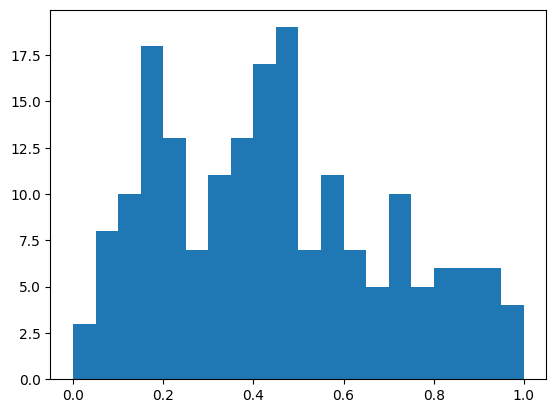

In [60]:
plt.hist(gcd, bins=np.linspace(0.0, 1.0, 21))

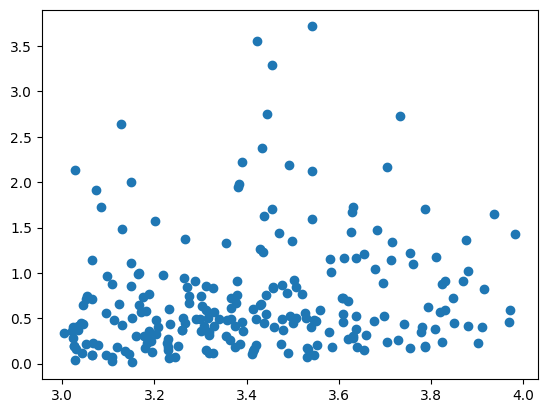

In [61]:
plt.scatter(jnp.log10(mctruth[:,0]), gcd)

Text(0, 0.5, 'tpn_spe1st [deg]')

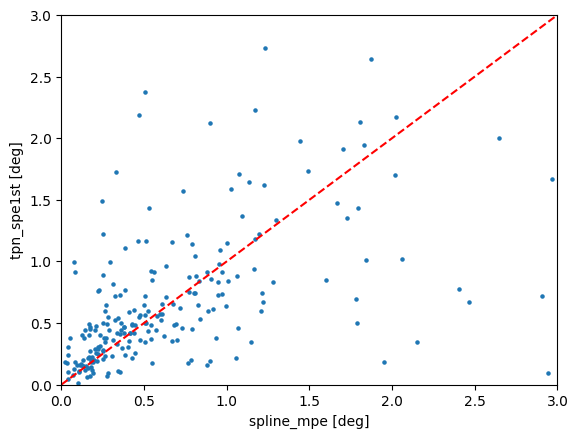

In [64]:
plt.scatter(gcd_smpe, gcd, s=5)
plt.xlim([0.0, 3.0])
plt.ylim([0.0, 3.0])
plt.plot([0.0, 3.0], [0.0, 3.0], "r--")
plt.xlabel("spline_mpe [deg]")
plt.ylabel("tpn_spe1st [deg]")

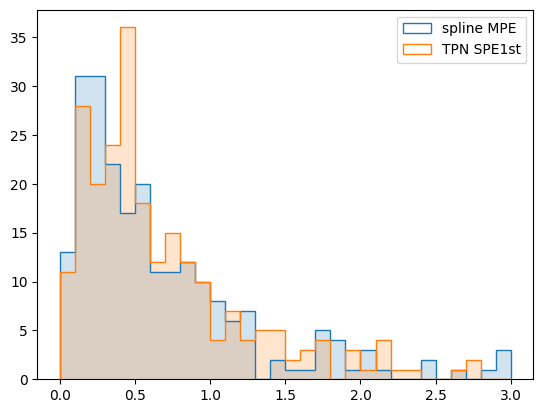

In [72]:
fig, ax = plt.subplots()
bins = np.linspace(0.0, 3.0, 31)
ax.hist(gcd_smpe, bins=bins, histtype='step', color='tab:blue', label='spline MPE')
ax.hist(gcd_smpe, bins=bins, color='tab:blue', alpha=0.2)
ax.hist(gcd, bins=bins, histtype='step', color='tab:orange', label='TPN SPE1st')
ax.hist(gcd, bins=bins, color='tab:orange', alpha=0.2)
ax.legend()
plt.show()